# The python way

In [8]:
from random import choice
from itertools import count, islice

random_chromosome = lambda: (choice([0, 1]) for _ in count())
random_population = lambda length: (list(islice(random_chromosome(), length)) 
                                    for _ in count())

In [19]:
populations = {length: list(islice(random_population(length), 10))
               for length in {5, 10, 20, 50}}

- 

In [26]:
populations[5]

[[1, 1, 0, 0, 0],
 [1, 1, 0, 1, 0],
 [1, 0, 1, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 1, 0, 1],
 [1, 1, 1, 1, 1],
 [1, 0, 1, 1, 0],
 [0, 1, 1, 1, 0],
 [0, 0, 0, 1, 1],
 [0, 0, 1, 0, 0]]

In [27]:
# Figure out fitness: represent fitness as average for each list.
def fitness(chromosome):
    return sum(chromosome) / len(chromosome)

In [28]:
fitness(populations[5][0])

0.4

In [29]:
[fitness(c) for c in populations[5]]

[0.4, 0.6, 0.6, 0.2, 0.6, 1.0, 0.6, 0.6, 0.4, 0.2]

In [32]:
def probabilities(population):
    fitnesses = [fitness(c) for c in population]
    total_fitness = sum(fitnesses)
    return (fitness/total_fitness for fitness in fitnesses)

In [33]:
list(probabilities(populations[5]))

[0.07692307692307693,
 0.11538461538461538,
 0.11538461538461538,
 0.038461538461538464,
 0.11538461538461538,
 0.1923076923076923,
 0.11538461538461538,
 0.11538461538461538,
 0.07692307692307693,
 0.038461538461538464]

In [56]:
from random import uniform, randrange
from copy import copy

def weighted_choice(choices, weights):
    totals = [weights[0]]
    for weight in weights[1:]:
        totals.append(totals[-1] + weight)
    threshold = uniform(0, totals[-1])
    for choice, total in zip(choices, totals):
        if total >= threshold:
            return choice
    return choice

def select(population):
    probs = list(probabilities(population))
    while True:
        x, y = weighted_choice(population, probs), \
               weighted_choice(population, probs)
        yield x, y

In [57]:
weighted_choice('abcde', [0, 1, 0, 1, 1])

'e'

In [58]:
next(select(populations[5]))

([0, 0, 1, 0, 0], [0, 1, 1, 0, 1])

In [59]:
def mutate(x):
    pos = randrange(0, len(x))
    z = copy(x)
    z[pos] = 0 if z[pos] else 1
    return z

In [60]:
populations[5][0], mutate(populations[5][0])

([1, 1, 0, 0, 0], [1, 1, 0, 1, 0])

In [68]:
def crossover(x, y):
    pos = randrange(0, len(x))
    if choice([True, False]):
        return x[pos:] + y[:pos]
    else:
        return y[pos:] + x[:pos]

In [75]:
x, y = next(select(populations[5]))
x, y

([0, 1, 1, 0, 1], [0, 1, 1, 0, 1])

In [76]:
crossover(x, y)

[1, 0, 1, 1, 0]

In [80]:
def breed(mates, mutation_rate=(1, 10000)):
    probs = [True] * mutation_rate[0] + [False] * mutation_rate[-1]
    for parents in mates:
        child = crossover(*parents)
        for _ in (None for _ in range(len(child)) if choice(probs)):
            child = mutate(child)
        yield child

In [81]:
mates = list(islice(select(populations[5]), 5))
mates

[([1, 1, 0, 0, 0], [1, 1, 1, 1, 1]),
 ([1, 1, 1, 1, 1], [1, 1, 1, 1, 1]),
 ([0, 1, 1, 1, 0], [0, 1, 1, 1, 0]),
 ([1, 1, 0, 1, 0], [0, 1, 1, 1, 0]),
 ([1, 1, 1, 1, 1], [1, 1, 1, 1, 1])]

In [82]:
list(breed(mates))

[[1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 0, 0],
 [1, 1, 0, 1, 0],
 [1, 1, 1, 1, 1]]

In [84]:
%%time

NUM_STEPS, POP_SIZE = 100, 100

# {5: [steps + runs] }
groups = {length: [] for length in {5, 10, 20, 50}}

for length, group in groups.items():
    population = list(islice(random_population(length), POP_SIZE))
    group.append(population)
    
    for step in range(0, NUM_STEPS):
        mates = islice(select(group[-1]), POP_SIZE)
        group.append(list(breed(mates)))

CPU times: user 1.83 s, sys: 7.21 ms, total: 1.84 s
Wall time: 1.84 s


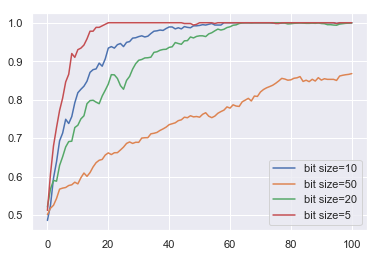

In [181]:
for length, group in groups.items():
    xs = range(NUM_STEPS+1)
    ys = [np.mean([fitness(c) for c in group[step]]) for step in range(NUM_STEPS+1)]
    plt.plot(xs, ys, label='bit size={}'.format(length))

plt.legend(loc='lower right');

# The numpy way

In [125]:
import numpy as np

from numpy import mean
from numpy.random import randint, choice

In [126]:
chromosome = randint(0, 2, size=(5,)).astype('bool')
chromosome

array([False, False, False,  True, False])

In [127]:
fitness = mean

In [128]:
population = randint(0, 2, size=(10, 5)).astype('bool')
population

array([[ True,  True,  True, False, False],
       [False,  True, False, False, False],
       [False, False, False,  True,  True],
       [ True,  True, False, False, False],
       [False,  True,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False,  True,  True,  True],
       [False,  True,  True, False, False],
       [False, False,  True,  True,  True],
       [False,  True, False, False,  True]])

In [129]:
def probabilities(population):
    """ Take mean across axis """
    fitness = mean(population, axis=1)
    return fitness / np.sum(fitness)

In [132]:
probabilities(population)

array([0.125     , 0.04166667, 0.08333333, 0.08333333, 0.16666667,
       0.08333333, 0.125     , 0.08333333, 0.125     , 0.08333333])

In [133]:
choice(range(0, population.shape[0]), p=probabilities(population), size=2)

array([2, 9])

In [135]:
mates = choice(range(0,population.shape[0]), p=probabilities(population), 
                 size=(10,2))

In [136]:
mates

array([[6, 8],
       [8, 5],
       [3, 0],
       [9, 8],
       [2, 5],
       [0, 9],
       [4, 4],
       [8, 9],
       [1, 0],
       [5, 4]])

In [168]:
chromosome[0] ^= True
chromosome

array([False,  True,  True, False,  True])

In [151]:
chromosome[randint(0, population.shape[1])] ^= False
chromosome

array([ True,  True,  True, False,  True])

In [169]:
a, b = population[0:2,]
a, b

(array([ True,  True,  True, False, False]),
 array([False,  True, False, False, False]))

In [178]:
pos = randint(0, a.shape[0])
z = np.empty_like(a)
z[:pos], z[pos:] = a[:pos], b[pos:]
pos, z

(0, array([False,  True, False, False, False]))

In [180]:
population[:, 3:6]

array([[False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False,  True]])